# ETH Stock Forcasting with Pytorch and LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# data = pd.read_csv('AMZN.csv')

In [2]:
import requests
import pandas as pd
import time

def fetch_binance_ohlcv(symbol='ETHUSDT', interval='1d', limit=1000, total=2000):
    url = 'https://api.binance.com/api/v3/klines'
    all_data = []
    end_time = None
    while len(all_data) < total:
        params = {
            'symbol': symbol,
            'interval': interval,
            'limit': min(limit, total - len(all_data))
        }
        if end_time:
            params['endTime'] = end_time
        resp = requests.get(url, params=params)
        data = resp.json()
        if not data:
            break
        all_data = data + all_data  # prepend
        end_time = data[0][0] - 1
        time.sleep(0.5)
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = df[col].astype(float)
    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

# # 获取最近600天ETH日线数据
# data = fetch_binance_ohlcv(total=3650)
# data.to_csv('eth_daily.csv', index=False)

data = pd.read_csv('eth_daily.csv', parse_dates=['timestamp'])
print(data.head())
print(f"共获取{len(data)}天数据")

   timestamp    open    high     low   close      volume
0 2017-08-17  301.13  312.18  298.00  302.00  7030.71034
1 2017-08-18  302.00  311.79  283.94  293.96  9537.84646
2 2017-08-19  293.31  299.90  278.00  290.91  2146.19773
3 2017-08-20  289.41  300.53  282.85  299.10  2510.13871
4 2017-08-21  299.10  346.52  294.60  323.29  5219.44542
共获取2844天数据


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

C:\Users\16244\AppData\Local\Temp\ipykernel_25928\2829609641.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f"{ts.strftime('%m-%d')}-{ts.hour+1}" for ts in data['timestamp']])


(array([17167., 17532., 17897., 18262., 18628., 18993., 19358., 19723.,
        20089.]),
 [Text(17167.0, 0, '08-17-1'),
  Text(17532.0, 0, '08-18-1'),
  Text(17897.0, 0, '08-19-1'),
  Text(18262.0, 0, '08-20-1'),
  Text(18628.0, 0, '08-21-1'),
  Text(18993.0, 0, '08-22-1'),
  Text(19358.0, 0, '08-23-1'),
  Text(19723.0, 0, '08-24-1'),
  Text(20089.0, 0, '08-25-1')])

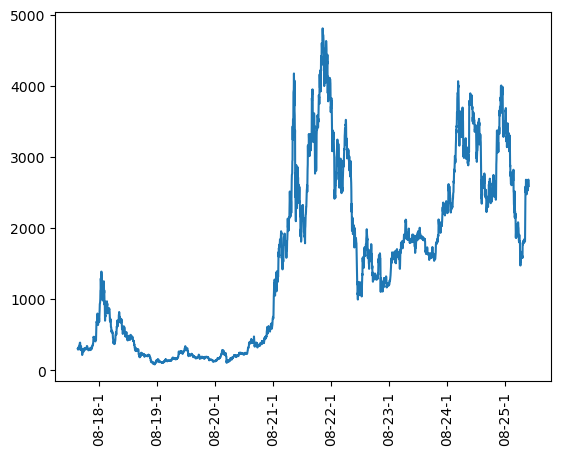

In [4]:
data['timestamp'] = pd.DataFrame(data['timestamp'])
# 格式化x轴标签为"05-26-1"、"05-26-2"等，每小时一个
plt.plot(data['timestamp'], data['close'])
plt.gca().set_xticklabels([f"{ts.strftime('%m-%d')}-{ts.hour+1}" for ts in data['timestamp']])
plt.xticks(rotation=90)

In [5]:
from copy import deepcopy as dc

lookback = 30
# To avoid DataFrame fragmentation, build all shifted columns first, then concat
shifted_cols = []
for i in range(1, lookback + 1):
    for col in ['open', 'high', 'low', 'close', 'volume']:
        shifted = data[col].shift(i)
        shifted.name = f'{col}(t-{i})'
        shifted_cols.append(shifted)
shifted_df = pd.concat([data] + shifted_cols, axis=1)
shifted_df.set_index('timestamp', inplace=True)
shifted_df.dropna(inplace=True)

shifted_df


,open,high,low,close,volume,open(t-1),high(t-1),low(t-1),close(t-1),volume(t-1),...,open(t-29),high(t-29),low(t-29),close(t-29),volume(t-29),open(t-30),high(t-30),low(t-30),close(t-30),volume(t-30)
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-16,255.99,271.81,235.51,249.31,10362.06011,217.00,270.93,192.00,253.00,14223.89530,...,302.00,311.79,283.94,293.96,9537.84646,301.13,312.18,298.00,302.00,7030.71034
2017-09-17,249.32,264.39,239.02,257.55,4614.53337,255.99,271.81,235.51,249.31,10362.06011,...,293.31,299.90,278.00,290.91,2146.19773,302.00,311.79,283.94,293.96,9537.84646
2017-09-18,257.53,306.22,257.11,294.57,4125.97051,249.32,264.39,239.02,257.55,4614.53337,...,289.41,300.53,282.85,299.10,2510.13871,293.31,299.90,278.00,290.91,2146.19773
2017-09-19,296.00,300.00,277.41,284.00,1869.90852,257.53,306.22,257.11,294.57,4125.97051,...,299.10,346.52,294.60,323.29,5219.44542,289.41,300.53,282.85,299.10,2510.13871
2017-09-20,284.01,294.00,275.91,282.00,1060.56734,296.00,300.00,277.41,284.00,1869.90852,...,321.04,330.41,144.21,309.80,7956.35088,299.10,346.52,294.60,323.29,5219.44542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26,2551.22,2599.00,2525.86,2563.70,362971.11820,2530.41,2554.26,2463.00,2551.22,359890.02990,...,1820.87,1857.47,1781.90,1791.29,340332.64350,1784.60,1841.16,1778.94,1820.88,355068.04420
2025-05-27,2563.70,2712.36,2509.46,2660.81,798430.88620,2551.22,2599.00,2525.86,2563.70,362971.11820,...,1791.29,1827.98,1744.71,1799.88,587269.74300,1820.87,1857.47,1781.90,1791.29,340332.64350
2025-05-28,2660.81,2689.14,2608.50,2681.60,560095.68330,2563.70,2712.36,2509.46,2660.81,798430.88620,...,1799.88,1842.99,1780.47,1797.81,480456.38840,1791.29,1827.98,1744.71,1799.88,587269.74300


In [6]:
feature_cols = []
for i in range(lookback, 0, -1):
    for col in ['open', 'high', 'low', 'close', 'volume']:
        feature_cols.append(f'{col}(t-{i})')
X = shifted_df[feature_cols].to_numpy()
y = shifted_df['close'].to_numpy()
print(X.shape, y.shape)


(2814, 150) (2814,)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# reshape for LSTM: (samples, lookback, features)
X = X.reshape((-1, lookback, 5))
X.shape

(2814, 30, 5)

In [8]:
X = dc(np.flip(X,axis=1))
X

array([[[-0.94358869, -0.92225382, -0.95241467, -0.92835219,
         -0.99435314],
        [-0.91871268, -0.9168848 , -0.94248397, -0.9443506 ,
         -0.99504893],
        [-0.91102042, -0.91239808, -0.92432806, -0.91822989,
         -0.99768749],
        ...,
        [-0.9112829 , -0.91014008, -0.91528249, -0.91230298,
         -0.99953428],
        [-0.90760399, -0.9051683 , -0.91271777, -0.91101176,
         -0.99636338],
        [-0.9079723 , -0.90500523, -0.90664709, -0.90760803,
         -0.9974389 ]],

       [[-0.9270823 , -0.92188585, -0.93362838, -0.92991436,
         -0.99600981],
        [-0.94358869, -0.92225382, -0.95241467, -0.92835219,
         -0.99435314],
        [-0.91871268, -0.9168848 , -0.94248397, -0.9443506 ,
         -0.99504893],
        ...,
        [-0.91293396, -0.90987665, -0.9131884 , -0.90883574,
         -0.99937816],
        [-0.9112829 , -0.91014008, -0.91528249, -0.91230298,
         -0.99953428],
        [-0.90760399, -0.9051683 , -0.91271777, 

In [9]:
split_index = int(len(X)*0.95)
split_index

2673

In [10]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [11]:
X_train = X_train.reshape((-1,lookback,5))
X_test = X_test.reshape((-1,lookback,5))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [13]:
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i],self.y[i]

train_dataset = TimeSeriesDataset(X_train,y_train)
test_dataset = TimeSeriesDataset(X_test,y_test)

In [14]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [15]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stzcked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
    
    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stzcked_layers,batch_size,self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stzcked_layers,batch_size,self.hidden_size).to(device)
        out,_ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out
model = LSTM(5,8,6)
if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('eth_lstm_model.pth', map_location=device))
    print("已加载保存的模型参数")
model.to(device)


LSTM(
  (lstm): LSTM(5, 8, num_layers=6, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [16]:
loss_array = []

def train_one_epoch():
    model.train(True)
    print(f'Epoch:{epoch+1}')
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output,y_batch)
        
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss/100
            print('Batch {0}, Loss:{1:3f}'.format(batch_index,avg_loss_across_batches))
            loss_array.append(loss.item())
            running_loss = 0.0
        
    print()



In [17]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index,batch in enumerate(train_loader):
        x_batch,y_batch = batch[0].to(device),batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output,y_batch)
            running_loss += loss.item()

        avg_loss_across_batches = running_loss/len(test_loader)
    print('Val Loss: {0:3f}'.format(avg_loss_across_batches))
    print('************************************************')
    print()

In [18]:
learning_rate = 0.0001
num_epoch = 2000
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epoch):
    train_one_epoch()
    validate_one_epoch()

# 保存loss_array为csv文件
np.savetxt('loss_array.csv', np.array(loss_array), delimiter=',', header='loss', comments='')

Epoch:1
Batch 99, Loss:0.737398

Val Loss: 12.254100
************************************************

Epoch:2
Batch 99, Loss:0.598231

Val Loss: 8.390456
************************************************

Epoch:3
Batch 99, Loss:0.339704

Val Loss: 3.713654
************************************************

Epoch:4
Batch 99, Loss:0.150272

Val Loss: 1.486667
************************************************

Epoch:5
Batch 99, Loss:0.069517

Val Loss: 0.981810
************************************************

Epoch:6
Batch 99, Loss:0.047513

Val Loss: 0.707374
************************************************

Epoch:7
Batch 99, Loss:0.033124

Val Loss: 0.566601
************************************************

Epoch:8
Batch 99, Loss:0.028667

Val Loss: 0.481236
************************************************

Epoch:9
Batch 99, Loss:0.025486

Val Loss: 0.419524
************************************************

Epoch:10
Batch 99, Loss:0.021580

Val Loss: 0.377246
****************************

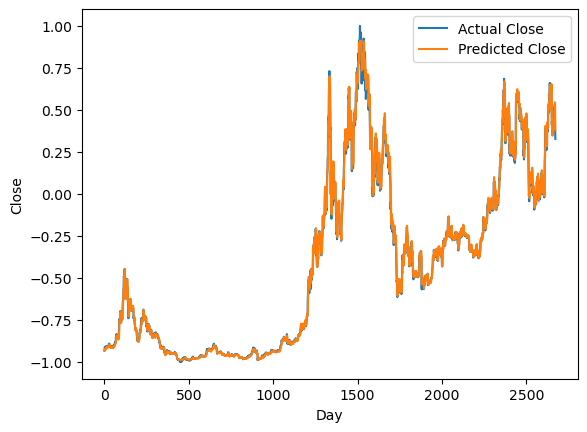

In [19]:
torch.save(model.state_dict(), 'eth_lstm_model.pth')
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train,label='Actual Close')
plt.plot(predicted,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

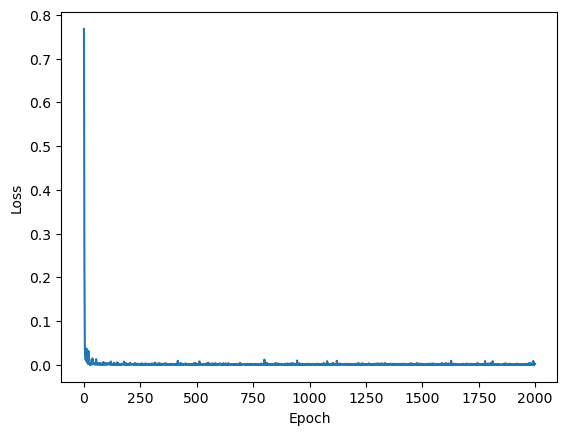

In [20]:
loss_df = pd.read_csv('loss_array.csv')
plt.plot(loss_df)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [21]:
train_predictions = predicted.flatten()
train_predictions.shape

dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = train_predictions
dummies = scaler_y.inverse_transform(dummies)

train_predictions = dc(dummies[:,0])
train_predictions

array([ 237.19760391,  236.60317701,  242.67810162, ..., 3733.60336802,
       3446.30538895, 3339.88607955])

In [22]:
dummies = np.zeros((X_train.shape[0],lookback+1))
dummies[:,0] = y_train.flatten()
dummies = scaler_y.inverse_transform(dummies)

new_y_train = dc(dummies[:,0])
new_y_train

array([ 249.31000225,  257.55003742,  294.56993639, ..., 3381.30997504,
       3327.28998779, 3219.20003189])

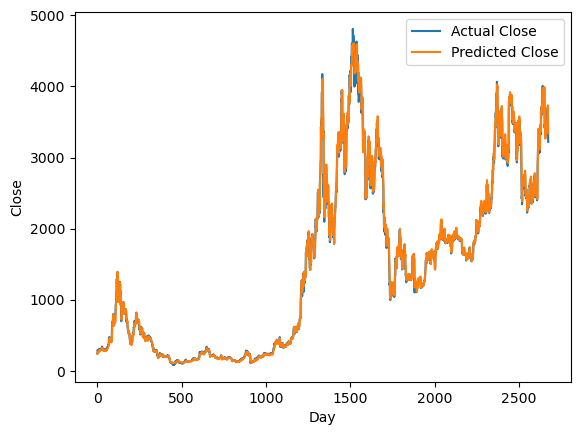

In [23]:
plt.plot(new_y_train,label='Actual Close')
plt.plot(train_predictions,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [24]:
test_prediction = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:,0] = test_prediction
dummies = scaler_y.inverse_transform(dummies)

test_prediction = dc(dummies[:,0])
test_prediction

array([3233.03883066, 3280.28556137, 3297.92372228, 3285.11214725,
       3161.30944138, 3238.17311905, 3467.32475762, 3356.59951384,
       3506.29041208, 3355.93180432, 3276.80087097, 3329.23989667,
       3346.59147399, 3273.29097867, 3349.59852507, 3346.50439369,
       3340.76441498, 3266.17517343, 3197.56582139, 3103.969984  ,
       3139.14127446, 3272.71492522, 3360.31482272, 3179.36280005,
       2924.04194683, 2841.89354374, 2760.47916353, 2818.04051025,
       2743.88304479, 2675.82077809, 2665.02718522, 2653.16934013,
       2685.44917034, 2642.31415044, 2768.391926  , 2717.87767767,
       2767.77099488, 2730.20605206, 2696.21228158, 2789.66961412,
       2717.11852329, 2748.10626344, 2775.75380173, 2721.72314944,
       2801.25675   , 2863.5615445 , 2579.8863031 , 2500.57916764,
       2356.66429105, 2318.2230191 , 2243.76267328, 2232.7410666 ,
       2525.90249959, 2236.42807615, 2192.02036039, 2268.81758389,
       2250.30671926, 2182.82187873, 2224.42929753, 2055.54884

In [25]:
dummies = np.zeros((X_test.shape[0],lookback+1))
dummies[:,0] = y_test.flatten()
dummies = scaler_y.inverse_transform(dummies)

new_y_test = dc(dummies[:,0])
new_y_test.shape

(141,)

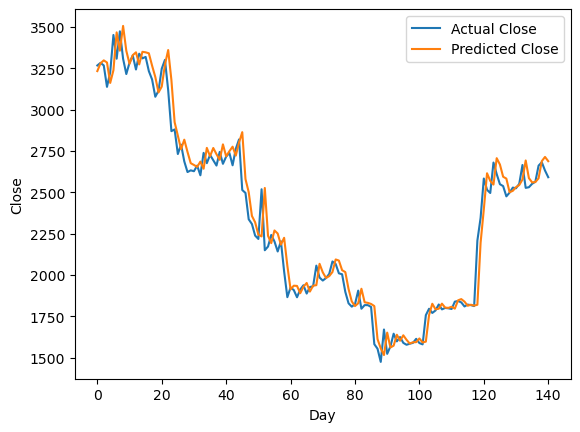

In [26]:
plt.plot(new_y_test,label='Actual Close')
plt.plot(test_prediction,label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

未来30天预测收盘价： [2687.913395052552, 2713.6965560451144, 2688.073405987322, 2584.3039565107224, 2561.6701176425813, 2560.0856362876293, 2586.0103643676634, 2693.532573598623, 2578.3910139387845, 2545.800806158483, 2533.9799895527954, 2512.566260460913, 2505.292626574337, 2590.5191106721754, 2603.448670006692, 2680.8629880353806, 2723.385489171445, 2566.111987401545, 2594.5057271468636, 2649.2727606019375, 2434.062347514331, 2237.6728246495127, 1863.726214146316, 1876.4762627533075, 1909.6513939198849, 1939.7024752566215, 2018.0477147993442, 2117.9386062195895, 2275.5305811390276, 2611.3106063050027]


d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\APP\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


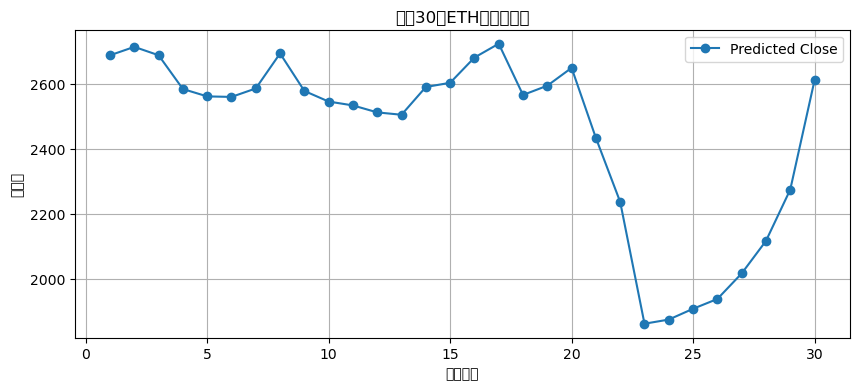

In [27]:
future_steps = 30
last_seq = X_test[-1].cpu().numpy()  # shape: (lookback, 5)
future_preds = []

for _ in range(future_steps):
    inp = torch.tensor(last_seq.reshape(1, lookback, 5), dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(inp).cpu().numpy()[0, 0]
    # 只反归一化1个值
    pred_real = scaler_y.inverse_transform([[pred]])[0, 0]
    future_preds.append(pred_real)
    # 更新last_seq，只更新close，其他特征保持不变
    new_row = last_seq[-1].copy()
    new_row[3] = pred  # 只更新close列（第4列，索引3）
    last_seq = np.vstack([last_seq[1:], new_row])


print("未来30天预测收盘价：", future_preds)

# 可视化未来30天预测收盘价
plt.figure(figsize=(10, 4))
plt.plot(range(1, future_steps + 1), future_preds, marker='o', label='Predicted Close')
plt.xlabel('未来天数')
plt.ylabel('收盘价')
plt.title('未来30天ETH收盘价预测')
plt.legend()
plt.grid(True)
plt.show()